In [5]:
# import packages and libraries

import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from numba import njit
from src._rbf import PairRBFSampler, required_rff_features
from sklearn.pipeline import make_pipeline

# off-the-shelf CPD
from changepoint_online import Focus, Gaussian, MDFocus, MDGaussian

# custom scripts
import _sgd_ocsvm
from _sgd_ocsvm import Sonar, detect_changepoint_sgd
import off_shelf_cpd
from off_shelf_cpd import detect_changepoint


def moving_average(x, window_size=10):
    return np.convolve(x, np.ones(window_size)/window_size, mode='valid')

import importlib
%load_ext autoreload

ModuleNotFoundError: No module named 'src'

In [2]:
# hyperparameter setup
random_state = 42 # for random seed
lambda_param = 0.01 # control on Type I error
gamma = 0.5 # kernel bandwidth

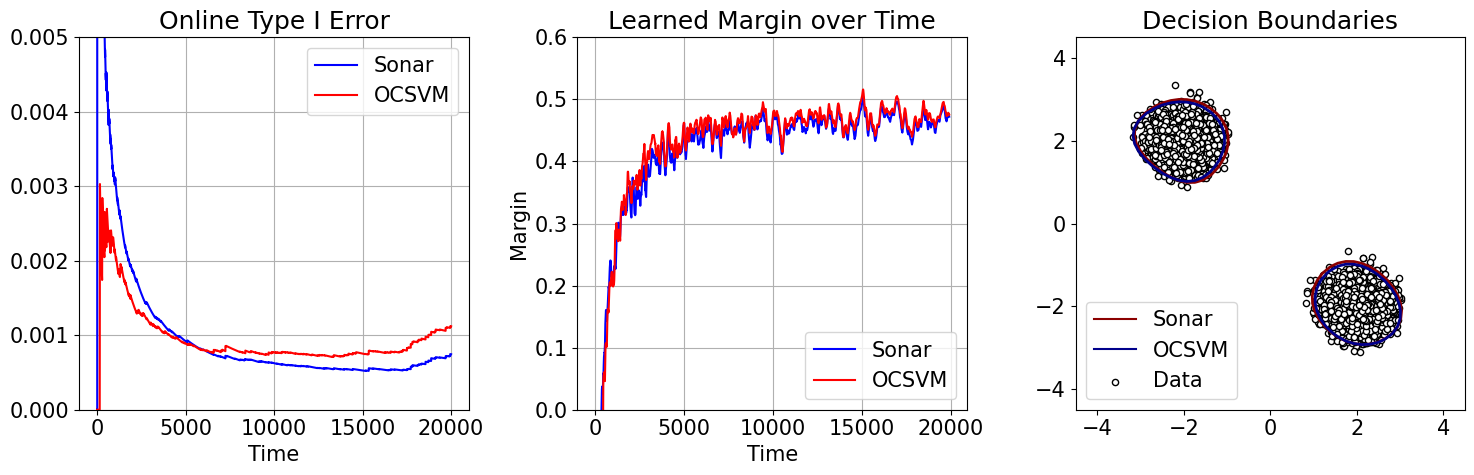

In [4]:
# Experiment 1 (SONAR vs OCSVM with SGD on a stationary environment)

# random seed
rng = np.random.RandomState(random_state)

# set up clusters
n_samples_per_cluster = 10000
std_dev = 0.3
cluster_centers = [ ((-2, 2), (2, -2)) ]

X_train_list = []

for center1, center2 in cluster_centers:
    # Sample shared base
    X = std_dev * rng.randn(n_samples_per_cluster, 2)

    # Create two clusters by shifting
    cluster1 = X + np.array(center1)
    cluster2 = X + np.array(center2)

    # Stack them into one chunk
    X_pair = np.r_[cluster1, cluster2]
    perm = rng.permutation(X_pair.shape[0])
    X_pair = X_pair[perm]
    X_train_list.append(X_pair)

# Concatenate all cluster pairs into final training set
X_train = np.vstack(X_train_list)

# run 20 simulations over RFF draws
D = X_train.shape[1] # ambient dimension
n_components = required_rff_features(D, lambda_param)

cumulative_errors_list = []
cumulative_errors_ocsvm_list = []
radii_list = []
radii_ocsvm_list = []
Z_i0 = None
Z2_i0 = None
xx = None
yy = None

for i in range(20):
    transform = PairRBFSampler(gamma=gamma, random_state=i, n_components=n_components)

    clf = Sonar(lambda_param=lambda_param, 
                                    random_state=random_state, 
                                    max_iter=X_train.shape[0], 
                                    snapshot_iters=[2,19999],
                                    dynamic_rate=True,
                                    adagrad=False,
                                )
    clf_ocsvm = Sonar(lambda_param=lambda_param, 
                                    random_state=random_state, 
                                    max_iter=X_train.shape[0], 
                                    snapshot_iters=[2,19999],
                                    reg=False,
                                    dynamic_rate=True,
                                      adagrad=False,
                                )

    pipe = make_pipeline(transform, clf)
    pipe_ocsvm = make_pipeline(transform, clf_ocsvm)

    pipe.fit(X_train)
    pipe_ocsvm.fit(X_train)
    
    cumulative_errors_list.append(clf.cumulative_errors_)
    cumulative_errors_ocsvm_list.append(clf_ocsvm.cumulative_errors_)
    radii_list.append(clf.radii_)
    radii_ocsvm_list.append(clf_ocsvm.radii_)
    
    # Save decision boundaries for third plot
    if i == 0:
        xx, yy = np.meshgrid(np.linspace(-4.5, 4.5, 50), np.linspace(-4.5, 4.5, 50))
        X = np.concatenate([xx.ravel().reshape(-1, 1), yy.ravel().reshape(-1, 1)], axis=1)
        X_transformed = pipe.named_steps["pairrbfsampler"].transform(X)
        
        Z_i0 = pipe.named_steps["sonar"].decision_function(X_transformed).reshape(xx.shape)
        Z2_i0 = pipe_ocsvm.named_steps["sonar"].decision_function(X_transformed).reshape(xx.shape)

# Compute averages
cumulative_errors_avg = np.mean(cumulative_errors_list, axis=0)
cumulative_errors_ocsvm_avg = np.mean(cumulative_errors_ocsvm_list, axis=0)
radii_avg = np.mean(radii_list, axis=0)
radii_ocsvm_avg = np.mean(radii_ocsvm_list, axis=0)

# plotting
font = {"weight": "normal", "size": 15}
matplotlib.rc("font", **font)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax1 = axes[0]  # top
ax3 = axes[1]  # middle
ax2 = axes[2]  # bottom

# === LEFT: Online Type I Error ===
time_steps = np.arange(1, len(cumulative_errors_avg) + 1)
time_steps_ocsvm = np.arange(1, len(cumulative_errors_ocsvm_avg) + 1)

normalized_errors = cumulative_errors_avg / time_steps
normalized_errors_ocsvm = cumulative_errors_ocsvm_avg / time_steps_ocsvm

ax1.plot(time_steps, normalized_errors, color='blue', label='Sonar')
ax1.plot(time_steps_ocsvm, normalized_errors_ocsvm, color='red', label='OCSVM')
ax1.set_xlabel("Time")
ax1.set_title("Online Type I Error")
ax1.set_ylim((0,0.005))
ax1.grid(True)
ax1.legend()

# === CENTER: margin over time ===
window = 100
radii = moving_average(radii_avg, window)
radii_noref = moving_average(radii_ocsvm_avg, window)

ax3.plot(np.arange(len(radii)), radii, color='blue', label='Sonar')
ax3.plot(np.arange(len(radii_noref)), radii_noref, color='red', label='OCSVM')
ax3.set_xlabel("Time")
ax3.set_ylabel("Margin")
ax3.set_title("Learned Margin over Time")
ax3.grid(True)
ax3.legend()
ax3.set(
    ylim=(0,0.6),
)

# === RIGHT: Decision boundaries ===
c1 = ax2.contour(xx, yy, Z_i0, levels=[0], colors="darkred", linewidths=2)
c2 = ax2.contour(xx, yy, Z2_i0, levels=[0], colors="darkblue", linewidths=2)

# Training points
s = 20
train_indices = np.arange(20000)
b1 = ax2.scatter(X_train[train_indices, 0], X_train[train_indices, 1],
                 c="white", s=s, edgecolors="k")

# Axis settings
ax2.set(
    title="Decision Boundaries",
    xlim=(-4.5, 4.5),
    ylim=(-4.5, 4.5),
)

# Legend for decision boundaries and data
red_line = mlines.Line2D([], [], color="darkred")
blue_line = mlines.Line2D([], [], color="darkblue")

ax2.legend([red_line, blue_line, b1],
           ["Sonar", "OCSVM", "Data"],
           loc="lower left")

plt.tight_layout()
plt.savefig('figs/exp1.png')
plt.show()

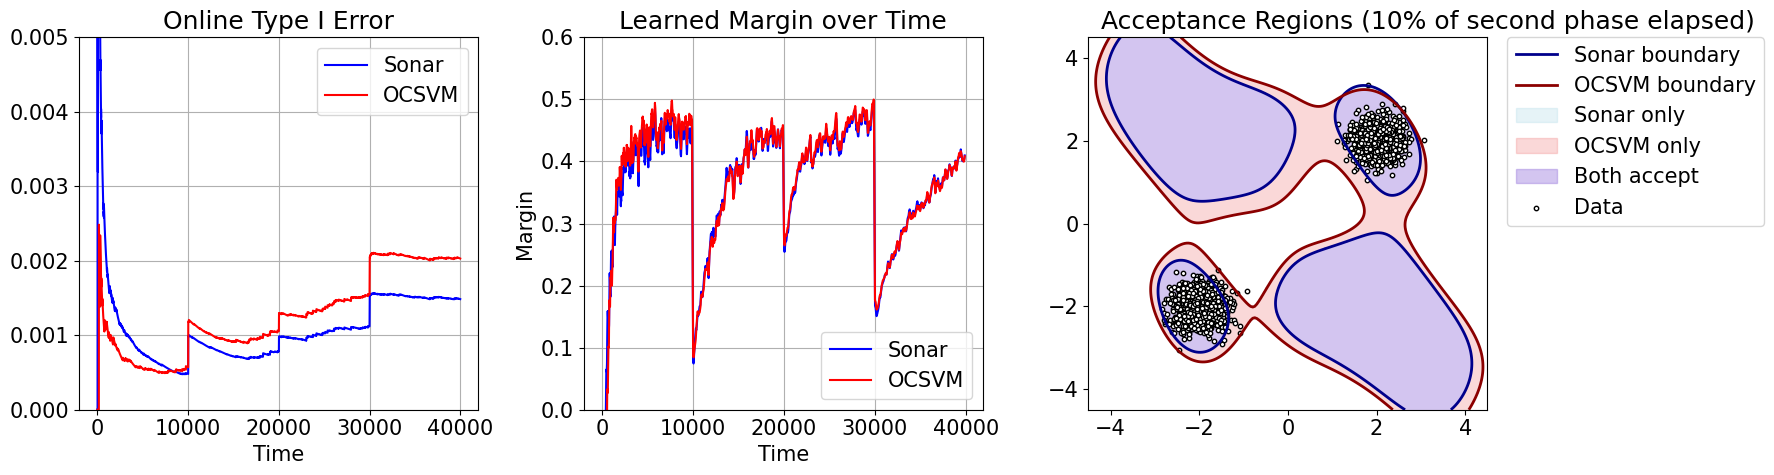

In [6]:
# Experiment 2 (Sonar vs OCSVM on Mildly Non-Stationary Environment)

# random seed
rng = np.random.RandomState(random_state)

# set up clusters
n_samples_per_cluster = 5000
std_dev = 0.3
cluster_centers = [
    ((-2, 2), (2, -2)),
    ((-2, -2), (2, 2)),
    ((2, 2), (2, -2)),
    ((-2, 2), (-2, -2)),
]
X_train_list = []

for center1, center2 in cluster_centers:
    # Sample shared base
    X = std_dev * rng.randn(n_samples_per_cluster, 2)

    # Create two clusters by shifting
    cluster1 = X + np.array(center1)
    cluster2 = X + np.array(center2)

    # Stack them into one chunk
    X_pair = np.r_[cluster1, cluster2]
    perm = rng.permutation(X_pair.shape[0])
    X_pair = X_pair[perm]
    X_train_list.append(X_pair)

# Concatenate all cluster pairs into final training set
X_train = np.vstack(X_train_list)


# run 20 simulations over RFF draws
D = X_train.shape[1] # ambient dimension
n_components = required_rff_features(D, lambda_param)

cumulative_errors_list = []
cumulative_errors_ocsvm_list = []
radii_list = []
radii_ocsvm_list = []
Z_i0 = None
Z2_i0 = None
xx = None
yy = None

for i in range(20):    
    transform = PairRBFSampler(gamma=gamma, random_state=i, n_components=n_components)
    clf = Sonar(lambda_param=0.01, 
                                    random_state=random_state, 
                                    max_iter=X_train.shape[0], 
                                    snapshot_iters=[2,9999,11999,29999,30999],
                                    dynamic_rate=True,
                                    adagrad=False
                                )
    clf_ocsvm = Sonar(lambda_param=0.01, 
                                    random_state=random_state, 
                                    max_iter=X_train.shape[0], 
                                    snapshot_iters=[2,9999,11999,29999,30499],
                                    reg=False,
                                    dynamic_rate=True,
                                      adagrad=False
                                )
    pipe = make_pipeline(transform, clf)
    pipe_ocsvm = make_pipeline(transform, clf_ocsvm)

    pipe.fit(X_train)
    pipe_ocsvm.fit(X_train)
    
    cumulative_errors_list.append(clf.cumulative_errors_)
    cumulative_errors_ocsvm_list.append(clf_ocsvm.cumulative_errors_)
    radii_list.append(clf.radii_)
    radii_ocsvm_list.append(clf_ocsvm.radii_)
    
    # Save decision boundaries for plotting
    if i == 11:
        xx, yy = np.meshgrid(np.linspace(-4.5, 4.5, 200), np.linspace(-4.5, 4.5, 200))
        X = np.concatenate([xx.ravel().reshape(-1, 1), yy.ravel().reshape(-1, 1)], axis=1)
        X_transformed = pipe.named_steps["pairrbfsampler"].transform(X)
        
        model = pipe.named_steps["sonar"]
        model_ocsvm = pipe_ocsvm.named_steps["sonar"]
        
        ind = 2
        w, rho = model.snapshots_[ind]
        Z_i0 = np.dot(X_transformed, w) - rho
        Z_i0 = Z_i0.reshape(xx.shape)

        w2, rho2 = model_ocsvm.snapshots_[ind]
        Z2_i0 = np.dot(X_transformed, w2) - rho2
        Z2_i0 = Z2_i0.reshape(xx.shape)


# Compute averages over RFF draws
cumulative_errors_avg = np.mean(cumulative_errors_list, axis=0)
cumulative_errors_ocsvm_avg = np.mean(cumulative_errors_ocsvm_list, axis=0)
radii_avg = np.mean(radii_list, axis=0)
radii_ocsvm_avg = np.mean(radii_ocsvm_list, axis=0)

# plotting
font = {"weight": "normal", "size": 15}
matplotlib.rc("font", **font)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Access each axis
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]

# === LEFT: Online Type I error over time ===
time_steps = np.arange(1, len(cumulative_errors_avg) + 1)
time_steps_ocsvm = np.arange(1, len(cumulative_errors_ocsvm_avg) + 1)

normalized_errors = cumulative_errors_avg / time_steps
normalized_errors_ocsvm = cumulative_errors_ocsvm_avg / time_steps_ocsvm

ax1.plot(time_steps, normalized_errors, color='blue', label='Sonar')
ax1.plot(time_steps_ocsvm, normalized_errors_ocsvm, color='red', label='OCSVM')

ax1.set_xlabel("Time")
ax1.set_title("Online Type I Error")
ax1.grid(True)
ax1.set_ylim((0,0.005))
ax1.legend()

# === MIDDLE: margin over time ===
window_size=100
avg_radii_s = moving_average(radii_avg, window_size=window_size)
avg_radii_ocsvm_s = moving_average(radii_ocsvm_avg, window_size=window_size)

ax2.plot(np.arange(len(avg_radii_s)), avg_radii_s, color='blue', label='Sonar')
ax2.plot(np.arange(len(avg_radii_ocsvm_s)), avg_radii_ocsvm_s, color='red', label='OCSVM')
ax2.set_xlabel("Time")
ax2.set_ylabel("Margin")
ax2.set_title("Learned Margin over Time")
ax2.grid(True)
ax2.legend()
ax2.set(
    ylim=(0,0.6),
)

# === RIGHT: Decision boundaries (2nd phase) ===
# Create acceptance region masks (positive values = accepted as normal)
Z_accept = (Z_i0 > 0).astype(float)
Z2_accept = (Z2_i0 > 0).astype(float)

# Create combined mask for intersection (both accept)
both_accept = (Z_accept * Z2_accept).astype(float)
Sonar_only = (Z_accept * (1 - Z2_accept)).astype(float)
ocsvm_only = (Z2_accept * (1 - Z_accept)).astype(float)

# Plot shaded regions
# Sonar only (red)
ax3.contourf(xx, yy, Sonar_only, levels=[0.5, 1.5], colors=['lightblue'], alpha=0.3)
# OCSVM only (blue)
ax3.contourf(xx, yy, ocsvm_only, levels=[0.5, 1.5], colors=['lightcoral'], alpha=0.3)
# Both (purple/intersection)
ax3.contourf(xx, yy, both_accept, levels=[0.5, 1.5], colors=['mediumpurple'], alpha=0.4)

# Plot decision boundaries on top
c1 = ax3.contour(xx, yy, Z_i0, levels=[0], colors="darkblue", linewidths=2)
c2 = ax3.contour(xx, yy, Z2_i0, levels=[0], colors="darkred", linewidths=2)

# Training points
s = 10
ind = 2
train_indices = np.arange((ind-1)*2*n_samples_per_cluster,(ind-1)*2*n_samples_per_cluster+1999)
b1 = ax3.scatter(X_train[train_indices, 0], X_train[train_indices, 1],
                 c="white", s=s, edgecolors="k")

# Axis settings
ax3.set(
    xlim=(-4.5, 4.5),
    ylim=(-4.5, 4.5),
)
ax3.set_title("Acceptance Regions (10% of second phase elapsed)", x=0.85)

# Legend for decision boundaries and data
blue_line = mlines.Line2D([], [], color="darkblue", linewidth=2, label="Sonar boundary")
red_line = mlines.Line2D([], [], color="darkred", linewidth=2, label="OCSVM boundary")
blue_patch = mpatches.Patch(color='lightblue', alpha=0.3, label='Sonar only')
red_patch = mpatches.Patch(color='lightcoral', alpha=0.3, label='OCSVM only')
purple_patch = mpatches.Patch(color='mediumpurple', alpha=0.4, label='Both accept')

ax3.legend(
    [blue_line, red_line, blue_patch, red_patch, purple_patch, b1],
    ["Sonar boundary", "OCSVM boundary", "Sonar only", "OCSVM only", "Both accept", "Data"],
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.0
)

plt.tight_layout()
plt.savefig('figs/exp2.png', dpi=300, bbox_inches='tight')
plt.show()

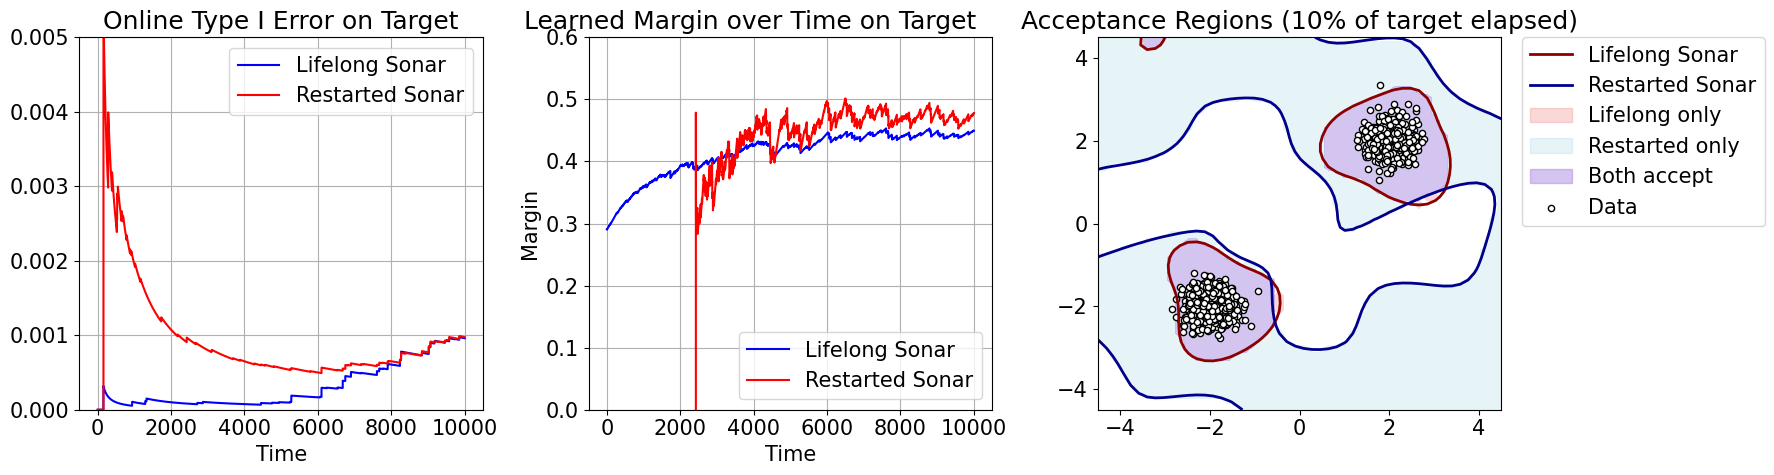

In [7]:
# Experiment 3 (demonstrating lifelong guarantees of Sonar or benefiting from past data)

# random seed
rng = np.random.RandomState(random_state)

# set up clusters
n_samples_per_cluster = 5000
source_std_dev = 0.6
target_std_dev = 0.3

# Define cluster centers as pairs of symmetric blobs
center1 = (-2,-2)
center2 = (2,2)
X_train_list = []
X_target_list = []

# source distribution
X = source_std_dev * rng.randn(n_samples_per_cluster, 2)
# Create two clusters by shifting
cluster1 = X + np.array(center1)
cluster2 = X + np.array(center2)

# Stack them into one chunk
X_pair = np.r_[cluster1, cluster2]
perm = rng.permutation(X_pair.shape[0])
X_pair = X_pair[perm]
X_train_list.append(X_pair)

# target distribution
X = target_std_dev * rng.randn(n_samples_per_cluster, 2)

# Create two clusters by shifting
cluster1 = X + np.array(center1)
cluster2 = X + np.array(center2)

# Stack them into one chunk
X_pair = np.r_[cluster1, cluster2]
perm = rng.permutation(X_pair.shape[0])
X_pair = X_pair[perm]
X_train_list.append(X_pair)
X_target_list.append(X_pair)
        
# Concatenate all cluster pairs into final training set
X_train = np.vstack(X_train_list)
X_target = np.vstack(X_target_list)


# run 20 simulations
D = X_train.shape[1] # ambient dimension
n_components = required_rff_features(D, lambda_param)

cumulative_errors_list = []
cumulative_errors_target_list = []
radii_list = []
radii_target_list = []
Z_i0 = None
Z2_i0 = None
xx = None
yy = None

for i in range(20):    
    transform = PairRBFSampler(gamma=gamma, random_state=i, n_components=n_components)

    clf = Sonar(lambda_param=0.01, 
                                    random_state=random_state, 
                                    max_iter=X_train.shape[0], 
                                    snapshot_iters=[2,9999,10999,14999,19999],
                                    learning_rate=1e-4,
                                    dynamic_rate=True
                                )
    clf_target = Sonar(lambda_param=0.01, 
                                    random_state=random_state, 
                                    max_iter=X_target.shape[0], 
                                    snapshot_iters=[2,999,4999,9999],
                                    learning_rate=1e-4,
                                    reg=False,
                                    dynamic_rate=True
                                )
    pipe = make_pipeline(transform, clf)
    pipe_target = make_pipeline(transform, clf_target)
    
    pipe.fit(X_train)
    pipe_target.fit(X_target)
    
    cumulative_errors_list.append(clf.cumulative_errors_)
    cumulative_errors_target_list.append(clf_target.cumulative_errors_)
    radii_list.append(clf.radii_)
    radii_target_list.append(clf_target.radii_)
    
    # Save decision boundaries for plotting
    if i == 2:
        xx, yy = np.meshgrid(np.linspace(-4.5, 4.5, 50), np.linspace(-4.5, 4.5, 50))
        X = np.concatenate([xx.ravel().reshape(-1, 1), yy.ravel().reshape(-1, 1)], axis=1)
        X_transformed = pipe.named_steps["pairrbfsampler"].transform(X)
        
        model = pipe.named_steps["sonar"]
        model_target = pipe_target.named_steps["sonar"]
        
        w, rho = model.snapshots_[2]
        Z_i0 = np.dot(X_transformed, w) - rho
        Z_i0 = Z_i0.reshape(xx.shape)
        
        w2, rho2 = model_target.snapshots_[1]
        Z2_i0 = np.dot(X_transformed, w2) - rho2
        Z2_i0 = Z2_i0.reshape(xx.shape)


# Compute averages
cumulative_errors_avg = np.mean(cumulative_errors_list, axis=0)
cumulative_errors_target_avg = np.mean(cumulative_errors_target_list, axis=0)
radii_avg = np.mean(radii_list, axis=0)
radii_target_avg = np.mean(radii_target_list, axis=0)

# Process for plotting
second_half = cumulative_errors_avg[10000:]
offset = cumulative_errors_avg[9999]
adjusted_second_half = second_half - offset
radii_second_half = radii_avg[10000:]

# plotting
font = {"weight": "normal", "size": 15}
matplotlib.rc("font", **font)

# Create 1 row, 3 columns layout
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
ax1 = axes[0]
ax4 = axes[1]
ax3 = axes[2]

# === LEFT: Online Type I error over time ===
time_steps = np.arange(1, len(adjusted_second_half) + 1)
time_steps_ocsvm = np.arange(1, len(cumulative_errors_target_avg) + 1)

normalized_errors = adjusted_second_half / time_steps
normalized_errors_ocsvm = cumulative_errors_target_avg / time_steps_ocsvm

ax1.plot(time_steps, normalized_errors, color='blue', label='Lifelong Sonar')
ax1.plot(time_steps_ocsvm, normalized_errors_ocsvm, color='red', label='Restarted Sonar')
ax1.set_xlabel("Time")
ax1.set_title("Online Type I Error on Target")
ax1.set_ylim((0,0.005))
ax1.grid(True)
ax1.legend()

# === MIDDLE: margin over time on target ===
ax4.plot(np.arange(len(radii_second_half)), radii_second_half, color='blue', label='Lifelong Sonar')
ax4.plot(np.arange(len(radii_target_avg)), radii_target_avg, color='red', label='Restarted Sonar')
ax4.set_xlabel("Time")
ax4.set_ylabel("Margin")
ax4.set_title("Learned Margin over Time on Target", x=0.4)
ax4.grid(True)
ax4.legend()
ax4.set(
    ylim=(0,0.6),
)

# === RIGHT: Decision boundaries ===
# Create acceptance region masks (positive values = accepted as normal)
Z_accept = (Z_i0 > 0).astype(float)
Z2_accept = (Z2_i0 > 0).astype(float)
# Create combined mask for intersection (both accept)
both_accept = (Z_accept * Z2_accept).astype(float)
lifelong_only = (Z_accept * (1 - Z2_accept)).astype(float)
restarted_only = (Z2_accept * (1 - Z_accept)).astype(float)

# Plot shaded regions
# Lifelong Sonar only (light red)
ax3.contourf(xx, yy, lifelong_only, levels=[0.5, 1.5], colors=['lightcoral'], alpha=0.3)
# Restarted Sonar only (light blue)
ax3.contourf(xx, yy, restarted_only, levels=[0.5, 1.5], colors=['lightblue'], alpha=0.3)
# Both (purple/intersection)
ax3.contourf(xx, yy, both_accept, levels=[0.5, 1.5], colors=['mediumpurple'], alpha=0.4)

# Plot decision boundaries on top
c1 = ax3.contour(xx, yy, Z_i0, levels=[0], colors="darkred", linewidths=2)
c2 = ax3.contour(xx, yy, Z2_i0, levels=[0], colors="darkblue", linewidths=2)

# Training points
s = 20
train_indices = np.arange(10000,10999)
b1 = ax3.scatter(X_train[train_indices, 0], X_train[train_indices, 1],
                 c="white", s=s, edgecolors="k")

# Axis settings
ax3.set(
    title="Acceptance Regions (10% of target elapsed)",
    xlim=(-4.5, 4.5),
    ylim=(-4.5, 4.5),
)

# Legend for decision boundaries and data
red_line = mlines.Line2D([], [], color="darkred", linewidth=2, label="Lifelong Sonar")
blue_line = mlines.Line2D([], [], color="darkblue", linewidth=2, label="Restarted Sonar")
red_patch = mpatches.Patch(color='lightcoral', alpha=0.3, label='Lifelong only')
blue_patch = mpatches.Patch(color='lightblue', alpha=0.3, label='Restarted only')
purple_patch = mpatches.Patch(color='mediumpurple', alpha=0.4, label='Both accept')
ax3.legend(
    [red_line, blue_line, red_patch, blue_patch, purple_patch, b1],
    ["Lifelong Sonar", "Restarted Sonar", "Lifelong only", "Restarted only", "Both accept", "Data"],
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.0
)

plt.tight_layout()
plt.savefig('figs/exp3.png')
plt.show()

In [8]:
# Experiment 5 (non-stationary environments)

# random seed
rng = np.random.RandomState(random_state)

# first set up environments

# set up clusters
n_samples_per_cluster = 5000
std_dev = 0.3

L = 10 # total number of phases
n_cluster_centers = L # number of clusters

def generate_random_disjoint_cluster_centers(n, low=-5, high=5, min_dist=3.0, random_state=None):
    rng = np.random.default_rng(random_state)
    pairs = []

    for _ in range(n):
        center1 = rng.uniform(low, high, size=2)
        
        # Rejection sampling for center2
        while True:
            center2 = rng.uniform(low, high, size=2)
            dist = np.linalg.norm(center2 - center1)
            if dist >= min_dist:
                break
        pairs.append((tuple(center1), tuple(center2)))
    return pairs

cluster_centers_unique = generate_random_disjoint_cluster_centers(n_cluster_centers, random_state=random_state)

# make training data
X_train_list = []
for center1, center2 in cluster_centers_unique:
    # Sample shared base
    X = std_dev * rng.randn(n_samples_per_cluster, 2)

    # Create two clusters by shifting
    cluster1 = X + np.array(center1)
    cluster2 = X + np.array(center2)

    # Stack them into one chunk
    X_pair = np.r_[cluster1, cluster2]
    perm = rng.permutation(X_pair.shape[0])
    X_pair = X_pair[perm]
    X_train_list.append(X_pair)

# Concatenate all cluster pairs into final training set
X_train = np.vstack(X_train_list)

# set hyperparameters and transform data
D = X_train.shape[1] # ambient dimension
n_components = required_rff_features(D, lambda_param) # number of RFF's
transform = PairRBFSampler(gamma=gamma, random_state=random_state, n_components=n_components)
transform.fit(X_train)
X_transformed = transform.transform(X_train)

# set total time horizon
T = X_train.shape[0]

In [9]:
# ==================================================================================
# RUN 20 SIMULATIONS FOR BASELINE Sonar, OCSVM WITH SGD, AND ORACLE RESTARTING Sonar
# =================================================================================
cumulative_errors_list = []
cumulative_errors_restarted_list = []
cumulative_errors_ocsvm_list = []
radii_list = []
radii_restarted_list = []
radii_ocsvm_list = []

for i in range(20):        
    transform = PairRBFSampler(gamma=gamma, random_state=i, n_components=n_components)
    transform.fit(X_train)
    X_transformed = transform.transform(X_train)
    
    clf = Sonar(lambda_param=lambda_param, 
                                    random_state=random_state, 
                                    max_iter=T, 
                                    snapshot_iters=[],
                                   )
    clf_restarted = Sonar(lambda_param=lambda_param, 
                                    random_state=random_state, 
                                    max_iter=T, 
                                    snapshot_iters=[],
                                    restarts = np.arange(2*n_samples_per_cluster, L*n_samples_per_cluster*2+1, n_samples_per_cluster*2)
                                )
    clf_ocsvm = Sonar(lambda_param=lambda_param, 
                                    random_state=random_state, 
                                    max_iter=T, 
                                    snapshot_iters=[],
                                    reg=False
                                   )
    
    clf.fit(X_transformed)
    clf_restarted.fit(X_transformed)
    clf_ocsvm.fit(X_transformed)
    
    cumulative_errors_list.append(clf.cumulative_errors_)
    cumulative_errors_restarted_list.append(clf_restarted.cumulative_errors_)
    cumulative_errors_ocsvm_list.append(clf_ocsvm.cumulative_errors_)
    radii_list.append(clf.radii_)
    radii_restarted_list.append(clf_restarted.radii_)
    radii_ocsvm_list.append(clf_ocsvm.radii_)

# compute averages of metrics
cumulative_errors_avg = np.mean(cumulative_errors_list, axis=0)
cumulative_errors_restarted_avg = np.mean(cumulative_errors_restarted_list, axis=0)
cumulative_errors_ocsvm_avg = np.mean(cumulative_errors_ocsvm_list, axis=0)
radii_avg = np.mean(radii_list, axis=0)
radii_restarted_avg = np.mean(radii_restarted_list, axis=0)
radii_ocsvm_avg = np.mean(radii_ocsvm_list, axis=0)

In [31]:
# Find smallest threshold which doesn't trigger a restart for off-the-shelf CPD method using representative 2-cluster environments

# set up clusters and create sample environments
N=20 # number of random environments
cluster_centers = cluster_centers_unique
X_train_list = []
for sim in range(N):
    for _ in range(len(cluster_centers)):  # or use some other loop count
        center1, center2 = cluster_centers[rng.randint(len(cluster_centers))]

        X = std_dev * rng.randn(n_samples_per_cluster, 2)
        cluster1 = X + np.array(center1)
        cluster2 = X + np.array(center2)

        X_pair = np.r_[cluster1, cluster2]
        perm = rng.permutation(X_pair.shape[0])
        X_pair = X_pair[perm]

        X_train_list.append(X_pair)

# Concatenate all cluster pairs into final training set
X_train_temp = np.vstack(X_train_list)

# set up search for optimal threshold
thresholds = [10,100,200,500,1000,10000] # thresholds for changepoint detection to try
search = True
i = 0

while search and (i < len(thresholds)):
    print(f"Trying threshold {thresholds[i]}")
    for n in range(N):
        X_temp = X_train_temp[n*2*n_samples_per_cluster : (n+1)*2*n_samples_per_cluster]
        result = detect_changepoint(X_temp,threshold = thresholds[i])
        if result:
            print(f"{n}/{N}: changes detected at threshold {thresholds[i]}")
            break
        elif n==N-1:
            search = False
    i+=1
# resulting threshold = 500

Trying threshold 10
0/20: changes detected at threshold 10
Trying threshold 100
0/20: changes detected at threshold 100
Trying threshold 200
0/20: changes detected at threshold 200
Trying threshold 500


In [10]:
# collect MDFocus restart times

restart_times = []
threshold = 500.0  # from tuning above

detector = MDFocus(MDGaussian(), pruning_params=(2, 1))

for t, y in enumerate(X_train):
    detector.update(y)

    if detector.statistic() >= threshold:
        cp = detector.changepoint()
        if cp is not None:
            restart_times.append(t)

        # Correct reset
        detector = MDFocus(MDGaussian(), pruning_params=(2, 1))

print("Detected restart times:")
for i, t_restart in enumerate(restart_times):
    print(f"{i+1:2d}: t = {t_restart}")

Detected restart times:
 1: t = 10687
 2: t = 22318
 3: t = 30039
 4: t = 40058
 5: t = 50016
 6: t = 60010
 7: t = 70041
 8: t = 80055
 9: t = 92580


In [11]:
# =============================================================================
# RUN 20 SIMULATIONS FOR Sonar USING MDFOCUS AS CPD
# =============================================================================
cumulative_errors_restart_cpd_list = []
radii_restart_cpd_list = []

for i in range(20):    
    transform = PairRBFSampler(gamma=gamma, random_state=i, n_components=n_components)
    transform.fit(X_train)
    X_transformed = transform.transform(X_train)
    
    clf_restart_cpd = Sonar(lambda_param=lambda_param, 
                                    random_state=random_state, 
                                    max_iter=T, 
                                    snapshot_iters=[],
                                    restarts = restart_times
                                )
    
    clf_restart_cpd.fit(X_transformed)
    
    cumulative_errors_restart_cpd_list.append(clf_restart_cpd.cumulative_errors_)
    radii_restart_cpd_list.append(clf_restart_cpd.radii_)

# compute averages of metrics
cumulative_errors_restart_cpd_avg = np.mean(cumulative_errors_restart_cpd_list, axis=0)
radii_restart_cpd_avg = np.mean(radii_restart_cpd_list, axis=0)

In [37]:
# Find smallest threshold which doesn't trigger a restart for SONARC

# set up clusters
N=10 # number of random environments
cluster_centers = cluster_centers_unique
X_train_list = []

for sim in range(N):
    for _ in range(len(cluster_centers)):  # or use some other loop count
        center1, center2 = cluster_centers[rng.randint(len(cluster_centers))]

        X = std_dev * rng.randn(n_samples_per_cluster, 2)
        cluster1 = X + np.array(center1)
        cluster2 = X + np.array(center2)

        X_pair = np.r_[cluster1, cluster2]
        perm = rng.permutation(X_pair.shape[0])
        X_pair = X_pair[perm]

        X_train_list.append(X_pair)

# Concatenate all cluster pairs into final training set
X_train_temp = np.vstack(X_train_list)
X_train_temp = transform.transform(X_train_temp)

thresholds = [1e-4,2.5e-5,1e-5]
search = True
i = 0
dyads_SONARC = [2,4,8,16,32]

while search and (i < len(thresholds)):
    print(f"Trying threshold {thresholds[i]}")
    for n in range(N):
        X_temp = X_train_temp[n*2*n_samples_per_cluster : (n+1)*2*n_samples_per_cluster]
        result = detect_changepoint_sgd(X_temp,
                              threshold = thresholds[i],
                              dyads=dyads_SONARC,
                              random_state=random_state,
                              lambda_param=lambda_param
                             )
        if result:
            print(f"{n}/{N}: changes detected at threshold {thresholds[i]}")
            break
    i+=1
# resulting threshold = 1e-4

Trying threshold 0.0001
Trying threshold 2.5e-05
Trying threshold 1e-05
0/10: changes detected at threshold 1e-05


In [12]:
# =============================================================================
# RUN 20 SIMULATIONS FOR SONARC
# =============================================================================
cumulative_errors_detect_list = []
radii_detect_list = []
detected_changes_list = []

for i in range(20):   
    transform = PairRBFSampler(gamma=gamma, random_state=i, n_components=n_components)
    transform.fit(X_train)
    X_transformed = transform.transform(X_train)
    
    dyads_SONARC = [2,4,8,16,64,128]
    restart_schedules = []
    for d in dyads_SONARC:
        phase_length = T // d
        restarts_for_d = [phase_length * k for k in range(1, d + 1)]
        restart_schedules.append(restarts_for_d)
    
    snapshots_all = []
    for j, restarts in enumerate(restart_schedules):
        snapshots_j = [r - 1 for r in restarts]
        clf_temp = Sonar(lambda_param=lambda_param, 
                                    random_state=random_state, 
                                    max_iter=T, 
                                    snapshot_iters=snapshots_j,
                                    restarts=restarts,
                                )
        clf_temp.fit(X_transformed)
        snapshots_all.append(clf_temp.snapshots_)
    
    clf_detect = Sonar(lambda_param=lambda_param, 
                                    random_state=random_state, 
                                    max_iter=T, 
                                    snapshot_iters=[],
                                    threshold = 2.5e-5,
                                    detect=True,
                                    base_schedules = restart_schedules,
                                    detect_snapshots = snapshots_all,
                                )
    clf_detect.fit_cpd(X_transformed)
    
    cumulative_errors_detect_list.append(clf_detect.cumulative_errors_)
    radii_detect_list.append(clf_detect.radii_)
    detected_changes_list.append(clf_detect.detected_changes_)

# compute average of metrics over RFF draws
cumulative_errors_detect_avg = np.mean(cumulative_errors_detect_list, axis=0)
radii_detect_avg = np.mean(radii_detect_list, axis=0)
detected_changes_avg = np.mean(detected_changes_list)

<Figure size 640x480 with 0 Axes>

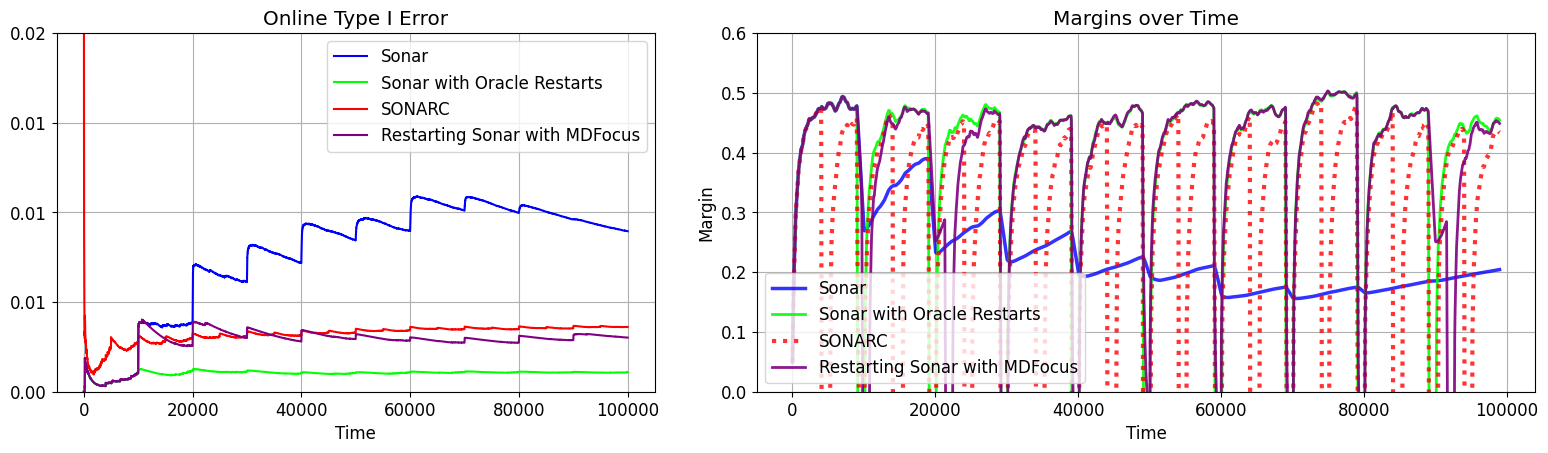

Final cumulative error (no restart): 0.0089485
Final cumulative error (oracle restart): 0.001087 restarting 10 times
Final cumulative error (cpd): 0.0030185000000000003
Final cumulative error (SONARC): 0.00361 restarting 19.0 times
Horizon: 100000


In [13]:
# plot comparison of non-stationary methods (including CPD now)
font = {"weight": "normal", "size": 12}
matplotlib.rc("font", **font)
plt.clf()
fig, axes = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={'width_ratios': [1, 1.3]})

# === LEFT: Cumulative 0-1 loss over time ===
cumulative_errors = cumulative_errors_avg
cumulative_errors_restarted = cumulative_errors_restarted_avg
cumulative_errors_cpd = cumulative_errors_restart_cpd_avg
cumulative_errors_detect = cumulative_errors_detect_avg
cum_errors_ocsvm = cumulative_errors_ocsvm_avg

# Normalize by time
time_steps = np.arange(1, len(cumulative_errors) + 1)
normalized_errors = cumulative_errors / time_steps
normalized_errors_restarted = cumulative_errors_restarted / time_steps
normalized_errors_cpd = cumulative_errors_cpd / time_steps
normalized_errors_detect = cumulative_errors_detect / time_steps
normalized_errors_ocsvm = cum_errors_ocsvm / time_steps

# Plot
ax1 = axes[0]
ax1.plot(time_steps, normalized_errors, color='blue', label='Sonar')
ax1.plot(time_steps, normalized_errors_restarted, color='lime', label='Sonar with Oracle Restarts')
ax1.plot(time_steps, normalized_errors_detect, color='red', label='SONARC')
ax1.plot(time_steps, normalized_errors_cpd, color='purple', label='Restarting Sonar with MDFocus')
ax1.set_xlabel("Time")
ax1.set_title("Online Type I Error")
ax1.set_ylim((0,0.02))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}'))
ax1.grid(True)
ax1.legend()

# margins
def moving_average(x, window_size=10):
    return np.convolve(x, np.ones(window_size)/window_size, mode='valid')

window_size = 1000
base_radii = moving_average(radii_avg, window_size=window_size)
restarted_radii = moving_average(radii_restarted_avg, window_size=window_size)
cpd_radii = moving_average(radii_restart_cpd_avg, window_size=window_size)
sgd_radii = moving_average(radii_detect_avg, window_size=window_size)
ocsvm_radiii = moving_average(radii_ocsvm_avg, window_size=window_size)

ax2 = axes[1]
# Use different line styles and thicknesses to distinguish overlapping curves
ax2.plot(np.arange(len(base_radii)), base_radii, color='blue', linestyle='-', linewidth=2.5, label='Sonar', alpha=0.8)
ax2.plot(np.arange(len(restarted_radii)), restarted_radii, color='lime', linestyle='-', linewidth=2, label='Sonar with Oracle Restarts', alpha=0.9)
ax2.plot(np.arange(len(sgd_radii)), sgd_radii, color='red', linestyle=':', linewidth=3, label='SONARC', alpha=0.8)
ax2.plot(np.arange(len(cpd_radii)), cpd_radii, color='purple', linestyle='-', linewidth=2, label='Restarting Sonar with MDFocus', alpha=0.9)
ax2.set_xlabel("Time")
ax2.set_ylabel("Margin")
ax2.set_title("Margins over Time")
ax2.grid(True)
ax2.legend(loc="lower left")
ax2.set(
    ylim=(0,0.6),
)

plt.tight_layout(pad=2.0)
plt.savefig('figs/exp5.png', dpi=150)
plt.show()

print(f"Final cumulative error (no restart): {cumulative_errors[-1] / T}")
print(f"Final cumulative error (oracle restart): {cumulative_errors_restarted[-1] / T} restarting {L} times")
print(f"Final cumulative error (cpd): {cumulative_errors_cpd[-1] / T}")
print(f"Final cumulative error (SONARC): {cumulative_errors_detect[-1]/ T} restarting {detected_changes_avg} times")
print(f"Horizon: {X_train.shape[0]}")

In [40]:
# setup for experiment 6 (showing off-the-shelf CPD unnecessarily triggers)

# random seed
rng = np.random.RandomState(random_state)

def sample_truncated_gaussian(mean, cov, n_samples, radius=1.0, seed=None):
    rng = np.random.default_rng(seed)
    samples = []
    while len(samples) < n_samples:
        # Draw more than needed for efficiency
        batch = rng.multivariate_normal(mean, cov, size=2 * (n_samples - len(samples)))
        # Keep only those inside the unit disk
        mask = np.sum(batch**2, axis=1) <= radius**2
        accepted = batch[mask]
        samples.extend(accepted.tolist())
    return np.array(samples[:n_samples])

# Parameters
n_samples = 5000
cov = np.eye(2)

X_train_list = []
# Phase 1: centered at (0, 0)
X_phase1 = sample_truncated_gaussian(mean=[0, 0], cov=cov, n_samples=n_samples, seed=42)

# Phase 2: centered at (0.5, 0)
X_phase2 = sample_truncated_gaussian(mean=[0.75, 0], cov=cov, n_samples=n_samples, seed=43)

X_train_list.append(X_phase1)
X_train_list.append(X_phase2)

# Concatenate all cluster pairs into final training set
X_train = np.vstack(X_train_list)

# OCSVM/SONAR hyperparameters
D = X_train.shape[1] # ambient dimension
n_components = required_rff_features(D, lambda_param)
transform = PairRBFSampler(gamma=gamma, random_state=random_state, n_components=n_components) # using default n_component=100 monte carlo features
transform.fit(X_train)
X_transformed = transform.transform(X_train)

In [41]:
# experiment 6: tune CPD thresholds for MDFocus based on both phase 1 and phase 2 environments

# set up clusters
n_samples_per_cluster = 5000
N=20 # number of sample environments
X_train_temp = []

for sim in range(N):
    for _ in range(len(cluster_centers)):  # or use some other loop count
        X_pair = sample_truncated_gaussian(mean=[0.75, 0], cov=np.eye(2), n_samples=n_samples_per_cluster)
        if np.random.rand() < 0.5:
            X_pair = sample_truncated_gaussian(mean=[0, 0], cov=np.eye(2), n_samples=n_samples_per_cluster)
        
        perm = rng.permutation(X_pair.shape[0])
        X_pair = X_pair[perm]
        X_train_list.append(X_pair)

# Concatenate all cluster pairs into final training set
X_train_temp = np.vstack(X_train_list)


thresholds = [0.01,0.1,1,10]
search = True
i = 0

print("tuning MDFocus threshold")
while search and (i < len(thresholds)):
    print(f"Trying threshold {thresholds[i]}")
    for n in range(N):
        X_temp = X_train_temp[n*n_samples_per_cluster : (n+1)*n_samples_per_cluster]
        result = detect_changepoint(X_temp,threshold = thresholds[i])
        if result:
            print(f"{N}: changes detected at threshold {thresholds[i]}")
            break
    i+=1
# resulting threshold = 10




tuning MDFocus threshold
Trying threshold 0.01
20: changes detected at threshold 0.01
Trying threshold 0.1
20: changes detected at threshold 0.1
Trying threshold 1
20: changes detected at threshold 1
Trying threshold 10


In [45]:
# experiment 6: tune CPD thresholds for SONARC

print("tuning SGD iterate CPD threshold")
thresholds = [50,1]
search = True
i = 0
while search and (i < len(thresholds)):
    print(f"Trying threshold {thresholds[i]}")
    for n in range(N):
        X_temp = X_train_temp[n*2*n_samples_per_cluster : (n+1)*2*n_samples_per_cluster]
        result = detect_changepoint_sgd(X_temp,threshold = thresholds[i],dyads=dyads,random_state=random_state,lambda_param=lambda_param)
        if result:
            print(f"{N}: changes detected at threshold {thresholds[i]}")
            break
    i+=1
# resulting threshold = 50

tuning SGD iterate CPD threshold
Trying threshold 50
Trying threshold 1
20: changes detected at threshold 1


In [46]:
# run experiment 6

# now run off-the-shelf on tuned threshold
restart_times = []
threshold_mdfocus = 10.0  # from tuning above
threshold_SONARC = 50.0 # from tuning above

# collect MDFocus restart times
detector = MDFocus(MDGaussian(), pruning_params=(2, 1))
for t, y in enumerate(X_train):
    detector.update(y)

    if detector.statistic() >= threshold_mdfocus:
        cp = detector.changepoint()
        if cp is not None:
            restart_times.append(t)

        # Correct reset
        detector = MDFocus(MDGaussian(), pruning_params=(2, 1))

# =============================================================================
# RUN 20 SIMULATIONS FOR MDFOCUS-BASED MODEL AND SONARC
# =============================================================================
cumulative_errors_restart_cpd_list = []
radii_restart_cpd_list = []
cumulative_errors_detect_list = []
radii_detect_list = []
detected_changes_list = []

for i in range(20):    
    transform = PairRBFSampler(gamma=gamma, random_state=i, n_components=n_components)
    transform.fit(X_train)
    X_transformed = transform.transform(X_train)
    
    # CPD model
    snapshots = [4999,5599,6999,7999,9999]
    clf_restart_cpd = Sonar(lambda_param=lambda_param, 
                                    random_state=random_state, 
                                    max_iter=X_train.shape[0], 
                                    snapshot_iters=snapshots,
                                    dynamic_rate=True,
                                    restarts = restart_times
                                )
    clf_restart_cpd.fit(X_transformed)
    
    cumulative_errors_restart_cpd_list.append(clf_restart_cpd.cumulative_errors_)
    radii_restart_cpd_list.append(clf_restart_cpd.radii_)
    
    # SONARC
    T = X_train.shape[0]
    restart_schedules = []
    for d in dyads:
        phase_length = T // d
        restarts_for_d = [phase_length * k for k in range(1, d + 1)]
        restart_schedules.append(restarts_for_d)
    
    snapshots_all = []
    for j, restarts in enumerate(restart_schedules):
        snapshots_j = [r - 1 for r in restarts]
        clf_temp = Sonar(lambda_param=0.01, 
                                    random_state=random_state, 
                                    max_iter=T, 
                                    snapshot_iters=snapshots_j,
                                    restarts=restarts
                                )
        clf_temp.fit(X_transformed)
        snapshots_all.append(clf_temp.snapshots_)
    
    clf_detect = Sonar(lambda_param=lambda_param, 
                                    random_state=random_state, 
                                    max_iter=T, 
                                    snapshot_iters=snapshots,
                                    threshold = threshold_SONARC,
                                    detect=True,
                                    base_schedules = restart_schedules,
                                    detect_snapshots = snapshots_all,
                                )
    clf_detect.fit_cpd(X_transformed)
    
    cumulative_errors_detect_list.append(clf_detect.cumulative_errors_)
    radii_detect_list.append(clf_detect.radii_)
    detected_changes_list.append(clf_detect.detected_changes_)

# Compute averages
cumulative_errors_restart_cpd_avg = np.mean(cumulative_errors_restart_cpd_list, axis=0)
radii_restart_cpd_avg = np.mean(radii_restart_cpd_list, axis=0)
cumulative_errors_detect_avg = np.mean(cumulative_errors_detect_list, axis=0)
radii_detect_avg = np.mean(radii_detect_list, axis=0)
detected_changes_avg = np.mean(detected_changes_list)

print(f"final cum error (MDFocus): {cumulative_errors_restart_cpd_avg[-1]}")
print(f"{len(restart_times)} changes")
print(f"final cum error (SONARC): {cumulative_errors_detect_avg[-1]}")
print(f"{detected_changes_avg} changes (average)")
print(f"horizon: {T}")

final cum error (MDFocus): 4.0
1 changes
final cum error (SONARC): 14.9
0.0 changes (average)
horizon: 10000


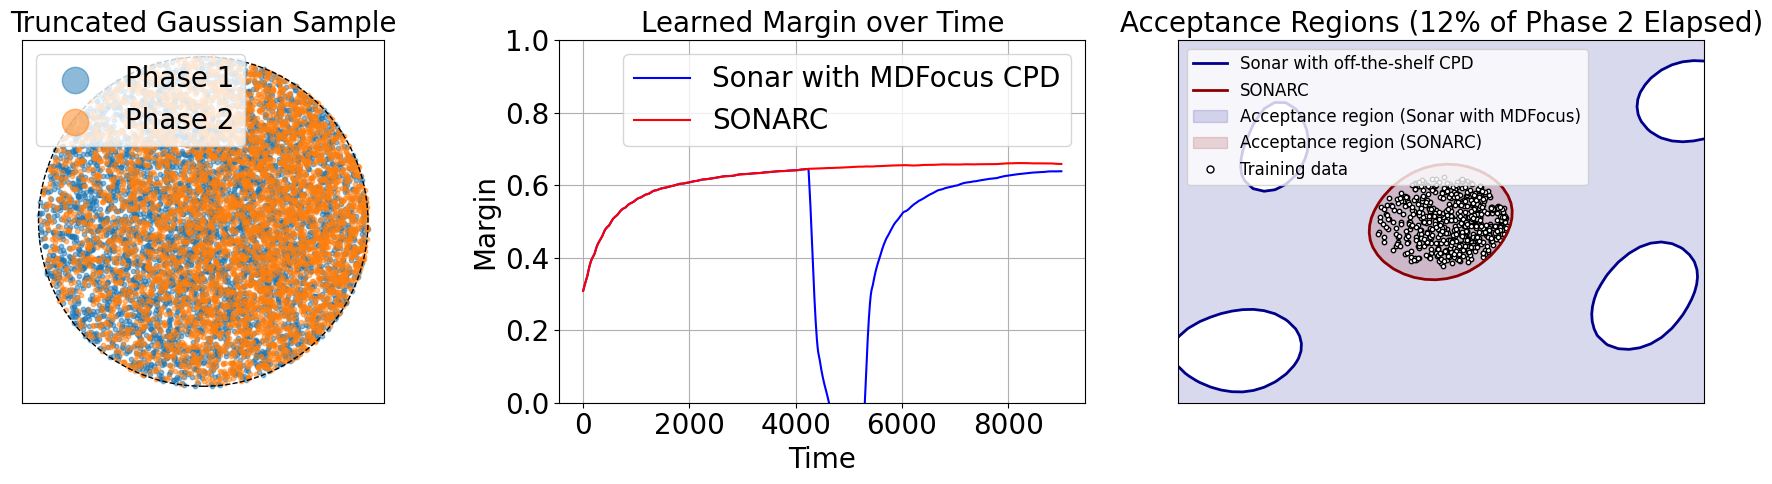

In [47]:
# plot stuff for Experiment 6
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
ax0 = axes[0]
ax3 = axes[1]
ax2 = axes[2]
f = 20

# === LEFT: plot data ===
ax0.scatter(X_phase1[:, 0], X_phase1[:, 1], alpha=0.5, s=10, label="Phase 1")
ax0.scatter(X_phase2[:, 0], X_phase2[:, 1], alpha=0.5, s=10, label="Phase 2")
circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle='--')
ax0.add_patch(circle)
ax0.set_aspect('equal')
ax0.set_title("Truncated Gaussian Sample", fontsize=f)
ax0.legend(fontsize=f, markerscale=6)
# Remove all ticks from first plot
ax0.set_xticks([])
ax0.set_yticks([])

# === MIDDLE: margin over time ===
window_size = 1000
radii = moving_average(radii_restart_cpd_avg, window_size=window_size)
radii_detect = moving_average(radii_detect_avg, window_size=window_size)

ax3.plot(np.arange(len(radii)), radii, color='blue', label='Sonar with MDFocus CPD')
ax3.plot(np.arange(len(radii_detect)), radii_detect, color='red', label='SONARC')
ax3.set_xlabel("Time",fontsize=f)
ax3.set_ylabel("Margin",fontsize=f)
ax3.set_title("Learned Margin over Time", fontsize=f)
ax3.grid(True)
ax3.legend(fontsize=f)
ax3.set(ylim=(0,1))
# Increase tick fontsize for second plot
ax3.tick_params(axis='both', labelsize=f)

# === RIGHT: Decision boundaries (using i=0 from the loop) ===
xx, yy = np.meshgrid(np.linspace(-4, 4, 50), np.linspace(-4, 4, 50))
X = np.concatenate([xx.ravel().reshape(-1, 1), yy.ravel().reshape(-1, 1)], axis=1)
X_transformed = transform.transform(X)

# models
model = clf_restart_cpd
model_detect = clf_detect

ind = 1
w, rho = model.snapshots_[ind]
Z = np.dot(X_transformed, w) - rho
Z = Z.reshape(xx.shape)

w2, rho2 = model_detect.snapshots_[ind]
Z2 = np.dot(X_transformed, w2) - rho2
Z2 = Z2.reshape(xx.shape)

# Shade acceptance regions (where decision function > 0)
ax2.contourf(xx, yy, Z, levels=[0, np.max(Z)], colors=['darkblue'], alpha=0.15)
ax2.contourf(xx, yy, Z2, levels=[0, np.max(Z2)], colors=['darkred'], alpha=0.15)

# Plot decision boundaries
c1 = ax2.contour(xx, yy, Z, levels=[0], colors="darkblue", linewidths=2)
c2 = ax2.contour(xx, yy, Z2, levels=[0], colors="darkred", linewidths=2)

# Training points
s = 10
train_indices = np.arange(snapshots[ind]-599, snapshots[ind])
b1 = ax2.scatter(X_train[train_indices, 0], X_train[train_indices, 1],
                 c="white", s=s, edgecolors="k")

# Legend for decision boundaries, shaded regions, and data
blue_line = mlines.Line2D([], [], color="darkblue", linewidth=2, label="Sonar with off-the-shelf CPD")
red_line = mlines.Line2D([], [], color="darkred", linewidth=2, label="SONARC")
blue_patch = mpatches.Patch(color="darkblue", alpha=0.15, label="Acceptance region (Sonar with MDFocus)")
red_patch = mpatches.Patch(color="darkred", alpha=0.15, label="Acceptance region (SONARC)")
white_dot = mlines.Line2D([], [], color="white", marker='o', linestyle='None',
                          markerfacecolor="white", markeredgecolor="k", markersize=5,
                          label="Training data")
ax2.legend(handles=[blue_line, red_line, blue_patch, red_patch, white_dot], 
           loc='upper left', fontsize=12)
ax2.set_title("Acceptance Regions (12% of Phase 2 Elapsed)", fontsize=f)

# Remove all ticks from third plot
ax2.set_xticks([])
ax2.set_yticks([])

plt.tight_layout()
plt.savefig('figs/exp6.png')
plt.show()